### Get NBA statistics

In [1]:
import pandas as pd
from nba_api.stats.endpoints import leagueleaders


first_year = 2003
last_year = 2023
leaders_df = []

for year in range(last_year-1, first_year-1, -1):
    season = "{}-{:02}".format(year, (year+1) % 100)
    leaders = leagueleaders.LeagueLeaders(per_mode48="Per48", scope="S", season=season, season_type_all_star="Regular Season")
    leaders_season_df = leaders.get_data_frames()[0]
    leaders_season_df["SEASON"] = season
    leaders_df.append(leaders_season_df)

leaders_df = pd.concat(leaders_df, ignore_index=True)

### Read targets data from csv

In [2]:
with open('target.csv') as csv_file:
    target_names_df = pd.read_csv(csv_file)
    target_names_df = target_names_df.iloc[:15, 1:(last_year-first_year)+1]

for season in target_names_df:
    target_names = target_names_df[season].tolist()    
    idxs = (leaders_df['SEASON'] == season) & (leaders_df['PLAYER'].isin(target_names))
    leaders_df.loc[idxs, 'TARGET'] = 1
    
leaders_df.fillna({'TARGET': 0}, inplace=True)

### Split into train and test data

In [3]:
test_seasons = ['2022-23', '2017-18', '2012-13', '2007-08']
train_df = leaders_df[~leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)
test_df = leaders_df[leaders_df['SEASON'].isin(test_seasons)].reset_index(drop=True)

### Prepare vectors of features and targets

In [4]:
from sklearn.preprocessing import MinMaxScaler


features = ['PTS', 'REB', 'FG3_PCT']
train_data = train_df[features]

scaler = MinMaxScaler()
scaler.fit_transform(train_data)

train_data_norm = scaler.transform(train_data)
train_target = train_df['TARGET'].to_numpy()

test_data_norm, test_target = [], []
for test_season in test_seasons:
    season_df = test_df[test_df['SEASON'] == test_season]

    test_data = season_df[features]
    test_data_norm.append(scaler.transform(test_data))
    test_target.append(season_df['TARGET'].to_numpy())

### Visualize data

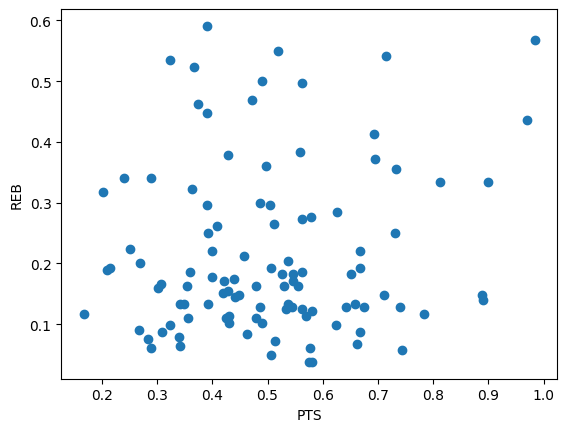

In [5]:
import matplotlib.pyplot as plt

test_season_idx = 0

plt.scatter(test_data_norm[test_season_idx][:, 0], test_data_norm[test_season_idx][:, 1])
plt.xlabel('PTS')
plt.ylabel('REB')
plt.show()

### Train model

In [6]:
from sklearn.ensemble import RandomForestRegressor


clf = RandomForestRegressor()
_ = clf.fit(train_data_norm, train_target)

### Test model

In [7]:
import numpy as np


for idx, test_season in enumerate(test_seasons):
    test_season_df = test_df[test_df['SEASON'] == test_season]

    predictions = clf.predict(test_data_norm[idx])
    top_15_idxs = np.argpartition(predictions, -15)[-15:]

    predictions_binary = np.zeros_like(predictions)
    predictions_binary[top_15_idxs] = 1

    print("Season ", test_season)
    print(test_season_df['PLAYER'][predictions_binary == 1].reset_index(drop=True), '\n')

Season  2022-23
0       Giannis Antetokounmpo
1                 Joel Embiid
2                 Luka Doncic
3              Damian Lillard
4     Shai Gilgeous-Alexander
5                Jayson Tatum
6            Donovan Mitchell
7             Lauri Markkanen
8                Jaylen Brown
9                Nikola Jokic
10               Kyrie Irving
11              DeMar DeRozan
12             Keldon Johnson
13              Pascal Siakam
14                Rudy Gobert
Name: PLAYER, dtype: object 

Season  2017-18
0              James Harden
1             Anthony Davis
2              Kevin Durant
3              LeBron James
4     Giannis Antetokounmpo
5         Russell Westbrook
6         LaMarcus Aldridge
7              Lou Williams
8             DeMar DeRozan
9           Dennis Schroder
10             Bradley Beal
11            Dwight Howard
12             Goran Dragic
13             Jusuf Nurkic
14             Clint Capela
Name: PLAYER, dtype: object 

Season  2012-13
0       Carmelo Anthon